## Setup

In [18]:
%matplotlib inline

In [19]:
from aif360.datasets import AdultDataset, GermanDataset, CompasDataset, BankDataset

In [20]:
from aif360.datasets import StandardDataset
StandardDataset??

In [21]:
import sys
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict
import pandas as pd
import statistics
from data_utils import DatasetBuilder
from metrics_utils import compute_metrics, describe_metrics, get_test_metrics, test
from plot_utils import plot
from mitigators import NullMitigator, SyntheticMitigator, DIRMitigator, ReweighMitigator, EGRMitigator, PRMitigator, CPPMitigator, ROMitigator 
from test_algorithms import TestAlgorithms
from plot_utils import plot_algo_lr, plot_algo

# Metrics
from aif360.metrics import BinaryLabelDatasetMetric

# Bias insertion
from oversample import label_bias, selection_bias 

## Arguments & Initializations

In [22]:
# construct argument parser
import argparse
ap = argparse.ArgumentParser()
ap.add_argument("-d", "--data", choices=['adult', 'compas', 'bank', 'meps19', 'grade', 'law_sex', 'german_age', 'german_foreign'], default='compas', help="dataset: adult, compas, german, bank, meps19, grade ")
ap.add_argument("-c", "--classifier", choices=['lr', 'rf', 'svm', 'nn', 'nb'], default='lr', help="baseline model: lr, rf, svm, nn, nb, dt")
ap.add_argument("-m", "--mitigator", choices=['dir', 'rew', 'egr', 'pr', 'cpp', 'ro'], required=False, help="mitigators: dir, rew, egr, pr, cpp, ro")
ap.add_argument("-b", "--bias", default=0., help="amount of bias: o-1")
ap.add_argument("-t", "--biastype", choices=['label', 'selection', 'none'], default='none', help="amount of bias: o-1")
ap.add_argument("-o", "--os", default=2, help="oversample mode: 1: privi unfav 2: unpriv fav")

_StoreAction(option_strings=['-o', '--os'], dest='os', nargs=None, const=None, default=2, type=None, choices=None, required=False, help='oversample mode: 1: privi unfav 2: unpriv fav', metavar=None)

In [23]:
import sys
sys.argv = ['']
args = vars(ap.parse_args())

In [24]:
args

{'data': 'compas',
 'classifier': 'lr',
 'mitigator': None,
 'bias': 0.0,
 'biastype': 'none',
 'os': 2}

In [25]:
DATASET = "german_foreign"#args["data"]
BASELINE = "dt" #args["classifier"]
MITIGATOR = args["mitigator"]
BIAS = float(args["bias"])
BIAS_TYPE = args["biastype"]
OS_MODE = int(args["os"])

In [26]:
# global constants
if BASELINE == 'svm' or BASELINE == 'nn':
    SCALER = False 
else:
    SCALER = False 
DISPLAY = False 
THRESH_ARR = 0.5

# loop ten times 
N = 3 

# percentage of favor and unfavor
priv_metric_orig = defaultdict(float)
favor_metric_orig = defaultdict(float)
favor_metric_transf = defaultdict(float)

# for each pre-processing approach, we create a mia_metric_results
orig_metrics = defaultdict(list)
orig_mia_metrics = defaultdict(list)

transf_metrics = defaultdict(list) 
transf_mia_metrics = defaultdict(list) 

reweigh_metrics = defaultdict(list) 
reweigh_mia_metrics = defaultdict(list) 

dir_metrics = defaultdict(list) 
dir_mia_metrics = defaultdict(list) 

egr_metrics = defaultdict(list) 
egr_mia_metrics = defaultdict(list) 


pr_orig_metrics = defaultdict(list) 
cpp_metrics = defaultdict(list) 
ro_metrics = defaultdict(list) 

## Loading & Splitting Dataset

In [27]:
# load dataset and set the groups
dataset_builder =  DatasetBuilder(DATASET)
dataset_orig = dataset_builder.load_data()
sens_attr = dataset_orig.protected_attribute_names[0]
unprivileged_groups = dataset_builder.unprivileged_groups
privileged_groups = dataset_builder.privileged_groups

# training data split ratio
p = 0.5

In [28]:
dataset_orig.features.shape

(1000, 56)

In [29]:
privileged_groups

[{'foreign': 1}]

In [30]:
# split dataset into train, validation, and test
dataset_orig_train, dataset_orig_test = dataset_orig.split([p], shuffle=True)
dataset_orig_val = dataset_orig_test
print(dataset_orig_train.features)

[[9.000e+00 6.540e+02 4.000e+00 ... 0.000e+00 1.000e+00 0.000e+00]
 [4.800e+01 3.578e+03 4.000e+00 ... 0.000e+00 0.000e+00 1.000e+00]
 [4.800e+01 5.381e+03 3.000e+00 ... 0.000e+00 0.000e+00 1.000e+00]
 ...
 [3.600e+01 3.249e+03 2.000e+00 ... 1.000e+00 0.000e+00 1.000e+00]
 [6.000e+00 1.872e+03 4.000e+00 ... 1.000e+00 0.000e+00 1.000e+00]
 [2.400e+01 1.469e+03 4.000e+00 ... 0.000e+00 1.000e+00 0.000e+00]]


In [31]:
# NOT SUITABLE
# favorable and unfavorable labels and feature_names
f_label = dataset_orig_train.favorable_label
uf_label = dataset_orig_train.unfavorable_label
feature_names = dataset_orig_train.feature_names

# introduce label or selection biases, assuming the original data is fair
if BIAS_TYPE == 'label':
    dataset_orig_train = label_bias(dataset_orig_train, unprivileged_groups, BIAS)
elif BIAS_TYPE == 'selection':
    dataset_orig_train = selection_bias(dataset_orig_train, unprivileged_groups, BIAS)
else:
    print('no bias type specified')

no bias type specified


In [32]:
dataset_orig_train

               instance weights features                \
                                                         
                                   month credit_amount   
instance names                                           
472                         1.0      9.0         654.0   
115                         1.0     48.0        3578.0   
310                         1.0     48.0        5381.0   
653                         1.0     36.0        8086.0   
612                         1.0     21.0        3357.0   
...                         ...      ...           ...   
34                          1.0     12.0        1474.0   
347                         1.0     24.0        3758.0   
392                         1.0     36.0        3249.0   
432                         1.0      6.0        1872.0   
100                         1.0     24.0        1469.0   

                                                                      \
                                                         

In [33]:
dataset_orig_train?

## Run Mitigating Algorithms

In [36]:
# run mitigating algorithms
for i in range(N):
    # split dataset into train, validation, and test
    dataset_orig_train, dataset_orig_test = dataset_orig.split([p], shuffle=True)
    dataset_orig_val = dataset_orig_test
    print("#### Train dataset's features are as below:")
    print(dataset_orig_train.features)

    # favorable and unfavorable labels and feature_names
    f_label = dataset_orig_train.favorable_label
    uf_label = dataset_orig_train.unfavorable_label
    feature_names = dataset_orig_train.feature_names

    # introduce label or selection biases, assuming the original data is fair
    if BIAS_TYPE == 'label':
        dataset_orig_train = label_bias(dataset_orig_train, unprivileged_groups, BIAS)
    elif BIAS_TYPE == 'selection':
        dataset_orig_train = selection_bias(dataset_orig_train, unprivileged_groups, BIAS)
    else:
        print('no bias type specified')

    # show data info
    print("#### Training Dataset shape")
    print(dataset_orig_train.features.shape)
    print("#### Favorable and unfavorable labels")
    print(dataset_orig_train.favorable_label, dataset_orig_train.unfavorable_label)
    print("#### Protected attribute names")
    print(dataset_orig_train.protected_attribute_names)
    print("#### Privileged and unprivileged protected groups")
    print(privileged_groups, unprivileged_groups)
    print("#### Privileged and unprivileged protected attribute values")
    print(dataset_orig_train.privileged_protected_attributes, dataset_orig_train.unprivileged_protected_attributes)
    print("#### Dataset feature names")
    print(dataset_orig_train.feature_names)

    # check fairness on the original data
    metric_orig_train = BinaryLabelDatasetMetric(dataset_orig_train, 
                                                 unprivileged_groups=unprivileged_groups,
                                                 privileged_groups=privileged_groups)
    print("privileged vs. unprivileged: ", metric_orig_train.num_positives(privileged=True) + metric_orig_train.num_negatives(privileged=True), metric_orig_train.num_positives(privileged=False) + metric_orig_train.num_negatives(privileged=False)) 
    base_rate_unprivileged = metric_orig_train.base_rate(privileged=False)
    base_rate_privileged = metric_orig_train.base_rate(privileged=True)
    print('base_pos unpriv: ', base_rate_unprivileged)
    print('base_pos priv: ', base_rate_privileged)
    print('number of favorable labels: ', np.count_nonzero(dataset_orig_train.labels==f_label))
    print("Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_orig_train.mean_difference())

    # statistics of favored/positive class BEFORE transf 
    priv_metric_orig['total_priv'] += metric_orig_train.num_instances(privileged = True) 
    priv_metric_orig['total_unpriv'] += metric_orig_train.num_instances(privileged = False) 
    favor_metric_orig['total_favor'] += metric_orig_train.base_rate()
    favor_metric_orig['total_unfavor'] += 1 - metric_orig_train.base_rate()
    favor_metric_orig['priv_favor'] += metric_orig_train.base_rate(privileged = True)
    favor_metric_orig['priv_unfavor'] += 1 - metric_orig_train.base_rate(privileged = True)
    favor_metric_orig['unpriv_favor'] += metric_orig_train.base_rate(privileged = False)
    favor_metric_orig['unpriv_unfavor'] += 1 - metric_orig_train.base_rate(privileged = False)

    print("#### Train shape, validation shape, test shape")
    print(dataset_orig_train.features.shape, dataset_orig_val.features.shape, dataset_orig_test.features.shape)

    # testing mitigation methods 
    test_cases = TestAlgorithms(BASELINE)

    # null mitigator
    orig_metrics, orig_mia_metrics = test_cases.run_original(dataset_orig_train, dataset_orig_val, dataset_orig_test, BASELINE, orig_metrics, orig_mia_metrics, f_label, uf_label, unprivileged_groups, privileged_groups, THRESH_ARR, DISPLAY, SCALER) 

    # synthetic data mitigator
    metric_transf_train, transf_metrics, transf_mia_metrics = test_cases.run_oversample(dataset_orig_train, dataset_orig_val, dataset_orig_test, privileged_groups, unprivileged_groups, base_rate_privileged, base_rate_unprivileged, BASELINE, transf_metrics, transf_mia_metrics, f_label, uf_label, THRESH_ARR, DISPLAY, OS_MODE, SCALER)
    
    # statistics of favored/positive class AFTER transf
    favor_metric_transf['total_favor'] += metric_transf_train.base_rate()
    favor_metric_transf['total_unfavor'] += 1 - metric_transf_train.base_rate()
    favor_metric_transf['priv_favor'] += metric_transf_train.base_rate(privileged = True)
    favor_metric_transf['priv_unfavor'] += 1 - metric_transf_train.base_rate(privileged = True)
    favor_metric_transf['unpriv_favor'] += metric_transf_train.base_rate(privileged = False)
    favor_metric_transf['unpriv_unfavor'] += 1 - metric_transf_train.base_rate(privileged = False)

    # dir mitigator
    dir_metrics, dir_mia_metrics = test_cases.run_dir(dataset_orig_train, dataset_orig_val, dataset_orig_test,  sens_attr, BASELINE, dir_metrics, dir_mia_metrics, f_label, uf_label, unprivileged_groups, privileged_groups, THRESH_ARR, DISPLAY, SCALER) 
    
    # reweigh mitigator
    reweigh_metrics, reweigh_mia_metrics = test_cases.run_rew(dataset_orig_train, dataset_orig_val, dataset_orig_test, f_label, uf_label,  unprivileged_groups, privileged_groups, BASELINE, reweigh_metrics, reweigh_mia_metrics, THRESH_ARR, DISPLAY, SCALER)

    # egr mitigator, in-processing
    train_test_egr, egr_metrics, egr_mia_metrics = test_cases.run_egr(dataset_orig_train, dataset_orig_val, dataset_orig_test, egr_metrics, egr_mia_metrics, BASELINE, f_label, uf_label, unprivileged_groups, privileged_groups,THRESH_ARR, DISPLAY, SCALER)
    # egr gave error so I replaced it with reweigh
#     egr_metrics, egr_mia_metrics = test_cases.run_rew(dataset_orig_train, dataset_orig_val, dataset_orig_test, f_label, uf_label,  unprivileged_groups, privileged_groups, BASELINE, egr_metrics, egr_mia_metrics, THRESH_ARR, DISPLAY, SCALER)

    # cpp mitigator
    cpp_metrics = test_cases.run_cpp(dataset_orig_train, dataset_orig_val, dataset_orig_test, cpp_metrics, BASELINE, unprivileged_groups, privileged_groups, THRESH_ARR, SCALER)

    # ro mitigator
    # ro_metrics = test_cases.run_ro(dataset_orig_train, dataset_orig_val, dataset_orig_test, ro_metrics, BASELINE, unprivileged_groups, privileged_groups, THRESH_ARR, SCALER)

    if (BASELINE == 'lr'):
        pr_orig_metrics = test_cases.run_pr(dataset_orig_train, dataset_orig_val, dataset_orig_test, pr_orig_metrics, sens_attr, f_label, uf_label, unprivileged_groups, privileged_groups, THRESH_ARR, DISPLAY, SCALER) 

#### Train dataset's features are as below:
[[1.8000e+01 1.2950e+03 4.0000e+00 ... 0.0000e+00 1.0000e+00 0.0000e+00]
 [2.7000e+01 5.1900e+03 4.0000e+00 ... 0.0000e+00 0.0000e+00 1.0000e+00]
 [5.4000e+01 1.5945e+04 3.0000e+00 ... 0.0000e+00 0.0000e+00 1.0000e+00]
 ...
 [2.7000e+01 2.5280e+03 4.0000e+00 ... 0.0000e+00 0.0000e+00 1.0000e+00]
 [1.2000e+01 3.0590e+03 2.0000e+00 ... 0.0000e+00 1.0000e+00 0.0000e+00]
 [3.6000e+01 8.1330e+03 1.0000e+00 ... 0.0000e+00 1.0000e+00 0.0000e+00]]
no bias type specified
#### Training Dataset shape
(500, 56)
#### Favorable and unfavorable labels
1.0 0.0
#### Protected attribute names
['foreign']
#### Privileged and unprivileged protected groups
[{'foreign': 1}] [{'foreign': 0}]
#### Privileged and unprivileged protected attribute values
[array([1.])] [array([0.])]
#### Dataset feature names
['month', 'credit_amount', 'investment_as_income_percentage', 'residence_since', 'age', 'number_of_credits', 'people_liable_for', 'foreign', 'status=A11', 'status=

              precision    recall  f1-score   support

         0.0       0.99      0.96      0.97       162
         1.0       1.00      1.00      1.00      1700

    accuracy                           1.00      1862
   macro avg       0.99      0.98      0.99      1862
weighted avg       1.00      1.00      1.00      1862

Train accuracy:  0.9957035445757251
Validating Original ...
Accuracy for threshold: 0.01  is: 0.662
Balanced accuracy is:  0.5917006966130195
Accuracy for threshold: 0.02  is: 0.662
Balanced accuracy is:  0.5917006966130195
Accuracy for threshold: 0.03  is: 0.662
Balanced accuracy is:  0.5917006966130195
Accuracy for threshold: 0.04  is: 0.662
Balanced accuracy is:  0.5917006966130195
Accuracy for threshold: 0.05  is: 0.662
Balanced accuracy is:  0.5917006966130195
Accuracy for threshold: 0.060000000000000005  is: 0.662
Balanced accuracy is:  0.5917006966130195
Accuracy for threshold: 0.06999999999999999  is: 0.662
Balanced accuracy is:  0.5917006966130195
Accuracy

[INFO]: training decision tree
####Train metrics:
Classification report for train: 
              precision    recall  f1-score   support

         0.0       0.96      0.97      0.96       162
         1.0       0.99      0.98      0.98       338

    accuracy                           0.98       500
   macro avg       0.97      0.97      0.97       500
weighted avg       0.98      0.98      0.98       500

Train accuracy:  0.976
Validating Original ...
Accuracy for threshold: 0.01  is: 0.706
Balanced accuracy is:  0.5951837617103051
Accuracy for threshold: 0.02  is: 0.706
Balanced accuracy is:  0.5951837617103051
Accuracy for threshold: 0.03  is: 0.706
Balanced accuracy is:  0.5951837617103051
Accuracy for threshold: 0.04  is: 0.706
Balanced accuracy is:  0.5951837617103051
Accuracy for threshold: 0.05  is: 0.706
Balanced accuracy is:  0.5951837617103051
Accuracy for threshold: 0.060000000000000005  is: 0.706
Balanced accuracy is:  0.5951837617103051
Accuracy for threshold: 0.06999999

Protected_attr_val, label, 1.0 0.0
Number of training samples (ntrain): 2
Number of test samples (ntest): 2
Protected_attr_val, label, 1.0 1.0
Number of training samples (ntrain): 21
Number of test samples (ntest): 12
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 500, Test = 500
  AUC: 0.67
  Privacy Risk: 0.66
  Accuracy: 0.66
  Train Accuracy (TPR): 0.94
  Test Accuracy (TNR): 0.37
  Attacker advantage: 0.32
  Positive predictive value: 0.60
  Optimal thershold: -0.16170528965505807
)
MIA_Result(
  Name: entire_dataset_label_0.0
  Size of the Dataset: Train = 162, Test = 138
  AUC: 0.75
  Privacy Risk: 0.75
  Accuracy: 0.77
  Train Accuracy (TPR): 0.94
  Test Accuracy (TNR): 0.56
  Attacker advantage: 0.50
  Positive predictive value: 0.71
  Optimal thershold: -0.7193423346069456
)
MIA_Result(
  Name: entire_dataset_label_1.0
  Size of the Dataset: Train = 338, Test = 362
  AUC: 0.63
  Privacy Risk: 0.63
  Accuracy: 0.61
  Train Accuracy (TPR): 0.95
  Test Accurac

C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:214: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  self.pos_basis[i]["+", e, g] = 1
C:\Users\ilham\AppData\Local\Program

Done fitting
Accuracy for threshold: 0.01  is: 0.362
Balanced accuracy is:  0.3934862679157659
Accuracy for threshold: 0.02  is: 0.362
Balanced accuracy is:  0.3934862679157659
Accuracy for threshold: 0.03  is: 0.362
Balanced accuracy is:  0.3934862679157659
Accuracy for threshold: 0.04  is: 0.362
Balanced accuracy is:  0.3934862679157659
Accuracy for threshold: 0.05  is: 0.362
Balanced accuracy is:  0.3934862679157659
Accuracy for threshold: 0.060000000000000005  is: 0.346
Balanced accuracy is:  0.422792057010169
Accuracy for threshold: 0.06999999999999999  is: 0.346
Balanced accuracy is:  0.422792057010169
Accuracy for threshold: 0.08  is: 0.346
Balanced accuracy is:  0.422792057010169
Accuracy for threshold: 0.09  is: 0.346
Balanced accuracy is:  0.422792057010169
Accuracy for threshold: 0.09999999999999999  is: 0.346
Balanced accuracy is:  0.422792057010169
Accuracy for threshold: 0.11  is: 0.346
Balanced accuracy is:  0.422792057010169
Accuracy for threshold: 0.12  is: 0.346
Balan

C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. U

Best balanced accuracy: 0.6276
Corresponding 1-min(DI, 1/DI) value: 0.6831
Corresponding average odds difference value: -0.3729
Corresponding statistical parity difference value: -0.3169
Corresponding equal opportunity difference value: -0.2457
Corresponding Theil index value: 0.2330
Corresponding false positive_rate for privileged: 1.0000
Corresponding false negative_rate for privileged: 0.0000
Corresponding false positive_rate for unpribileged: 0.5000
Corresponding false negative_rate for unprivileged: 0.2457
#### Train dataset's features are as below:
[[1.8000e+01 1.2950e+03 4.0000e+00 ... 0.0000e+00 1.0000e+00 0.0000e+00]
 [2.7000e+01 5.1900e+03 4.0000e+00 ... 0.0000e+00 0.0000e+00 1.0000e+00]
 [5.4000e+01 1.5945e+04 3.0000e+00 ... 0.0000e+00 0.0000e+00 1.0000e+00]
 ...
 [2.7000e+01 2.5280e+03 4.0000e+00 ... 0.0000e+00 0.0000e+00 1.0000e+00]
 [1.2000e+01 3.0590e+03 2.0000e+00 ... 0.0000e+00 1.0000e+00 0.0000e+00]
 [3.6000e+01 8.1330e+03 1.0000e+00 ... 0.0000e+00 1.0000e+00 0.0000e+

Train metrics:
Classification report for train: 
              precision    recall  f1-score   support

         0.0       0.99      0.96      0.97       162
         1.0       1.00      1.00      1.00      1700

    accuracy                           1.00      1862
   macro avg       0.99      0.98      0.99      1862
weighted avg       1.00      1.00      1.00      1862

Train accuracy:  0.9957035445757251
Validating Original ...
Accuracy for threshold: 0.01  is: 0.662
Balanced accuracy is:  0.5917006966130195
Accuracy for threshold: 0.02  is: 0.662
Balanced accuracy is:  0.5917006966130195
Accuracy for threshold: 0.03  is: 0.662
Balanced accuracy is:  0.5917006966130195
Accuracy for threshold: 0.04  is: 0.662
Balanced accuracy is:  0.5917006966130195
Accuracy for threshold: 0.05  is: 0.662
Balanced accuracy is:  0.5917006966130195
Accuracy for threshold: 0.060000000000000005  is: 0.662
Balanced accuracy is:  0.5917006966130195
Accuracy for threshold: 0.06999999999999999  is: 0.662
B

[INFO]: training decision tree
####Train metrics:
Classification report for train: 
              precision    recall  f1-score   support

         0.0       0.96      0.97      0.96       162
         1.0       0.99      0.98      0.98       338

    accuracy                           0.98       500
   macro avg       0.97      0.97      0.97       500
weighted avg       0.98      0.98      0.98       500

Train accuracy:  0.976
Validating Original ...
Accuracy for threshold: 0.01  is: 0.706
Balanced accuracy is:  0.5951837617103051
Accuracy for threshold: 0.02  is: 0.706
Balanced accuracy is:  0.5951837617103051
Accuracy for threshold: 0.03  is: 0.706
Balanced accuracy is:  0.5951837617103051
Accuracy for threshold: 0.04  is: 0.706
Balanced accuracy is:  0.5951837617103051
Accuracy for threshold: 0.05  is: 0.706
Balanced accuracy is:  0.5951837617103051
Accuracy for threshold: 0.060000000000000005  is: 0.706
Balanced accuracy is:  0.5951837617103051
Accuracy for threshold: 0.06999999

Accuracy for threshold: 0.21000000000000002  is: 0.666
Balanced accuracy is:  0.5967051004884298
Accuracy for threshold: 0.22  is: 0.666
Balanced accuracy is:  0.5967051004884298
Accuracy for threshold: 0.23  is: 0.666
Balanced accuracy is:  0.5967051004884298
Accuracy for threshold: 0.24000000000000002  is: 0.666
Balanced accuracy is:  0.5967051004884298
Accuracy for threshold: 0.25  is: 0.666
Balanced accuracy is:  0.5967051004884298
Accuracy for threshold: 0.26  is: 0.666
Balanced accuracy is:  0.5967051004884298
Accuracy for threshold: 0.27  is: 0.666
Balanced accuracy is:  0.5967051004884298
Accuracy for threshold: 0.28  is: 0.666
Balanced accuracy is:  0.5967051004884298
Accuracy for threshold: 0.29000000000000004  is: 0.666
Balanced accuracy is:  0.5967051004884298
Accuracy for threshold: 0.3  is: 0.666
Balanced accuracy is:  0.5967051004884298
Accuracy for threshold: 0.31  is: 0.666
Balanced accuracy is:  0.5967051004884298
Accuracy for threshold: 0.32  is: 0.666
Balanced accur

C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:214: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  self.pos_basis[i]["+", e, g] = 1
C:\Users\ilham\AppData\Local\Program

Done fitting
Accuracy for threshold: 0.01  is: 0.362
Balanced accuracy is:  0.3934862679157659
Accuracy for threshold: 0.02  is: 0.362
Balanced accuracy is:  0.3934862679157659
Accuracy for threshold: 0.03  is: 0.362
Balanced accuracy is:  0.3934862679157659
Accuracy for threshold: 0.04  is: 0.362
Balanced accuracy is:  0.3934862679157659
Accuracy for threshold: 0.05  is: 0.362
Balanced accuracy is:  0.3934862679157659
Accuracy for threshold: 0.060000000000000005  is: 0.346
Balanced accuracy is:  0.422792057010169
Accuracy for threshold: 0.06999999999999999  is: 0.346
Balanced accuracy is:  0.422792057010169
Accuracy for threshold: 0.08  is: 0.346
Balanced accuracy is:  0.422792057010169
Accuracy for threshold: 0.09  is: 0.346
Balanced accuracy is:  0.422792057010169
Accuracy for threshold: 0.09999999999999999  is: 0.346
Balanced accuracy is:  0.422792057010169
Accuracy for threshold: 0.11  is: 0.346
Balanced accuracy is:  0.422792057010169
Accuracy for threshold: 0.12  is: 0.346
Balan

C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. U

Best balanced accuracy: 0.6276
Corresponding 1-min(DI, 1/DI) value: 0.6831
Corresponding average odds difference value: -0.3729
Corresponding statistical parity difference value: -0.3169
Corresponding equal opportunity difference value: -0.2457
Corresponding Theil index value: 0.2330
Corresponding false positive_rate for privileged: 1.0000
Corresponding false negative_rate for privileged: 0.0000
Corresponding false positive_rate for unpribileged: 0.5000
Corresponding false negative_rate for unprivileged: 0.2457
#### Train dataset's features are as below:
[[1.8000e+01 1.2950e+03 4.0000e+00 ... 0.0000e+00 1.0000e+00 0.0000e+00]
 [2.7000e+01 5.1900e+03 4.0000e+00 ... 0.0000e+00 0.0000e+00 1.0000e+00]
 [5.4000e+01 1.5945e+04 3.0000e+00 ... 0.0000e+00 0.0000e+00 1.0000e+00]
 ...
 [2.7000e+01 2.5280e+03 4.0000e+00 ... 0.0000e+00 0.0000e+00 1.0000e+00]
 [1.2000e+01 3.0590e+03 2.0000e+00 ... 0.0000e+00 1.0000e+00 0.0000e+00]
 [3.6000e+01 8.1330e+03 1.0000e+00 ... 0.0000e+00 1.0000e+00 0.0000e+

origin, transf:  500 1862
after transf priv:  0.9130434782608695
after transf unpriv:  0.9129961935834693
Difference in mean outcomes between unprivileged and privileged groups = -0.000047
[INFO]: training decision tree
Train metrics:
Classification report for train: 
              precision    recall  f1-score   support

         0.0       0.99      0.96      0.97       162
         1.0       1.00      1.00      1.00      1700

    accuracy                           1.00      1862
   macro avg       0.99      0.98      0.99      1862
weighted avg       1.00      1.00      1.00      1862

Train accuracy:  0.9957035445757251
Validating Original ...
Accuracy for threshold: 0.01  is: 0.662
Balanced accuracy is:  0.5917006966130195
Accuracy for threshold: 0.02  is: 0.662
Balanced accuracy is:  0.5917006966130195
Accuracy for threshold: 0.03  is: 0.662
Balanced accuracy is:  0.5917006966130195
Accuracy for threshold: 0.04  is: 0.662
Balanced accuracy is:  0.5917006966130195
Accuracy for thr

[INFO]: training decision tree
####Train metrics:
Classification report for train: 
              precision    recall  f1-score   support

         0.0       0.96      0.97      0.96       162
         1.0       0.99      0.98      0.98       338

    accuracy                           0.98       500
   macro avg       0.97      0.97      0.97       500
weighted avg       0.98      0.98      0.98       500

Train accuracy:  0.976
Validating Original ...
Accuracy for threshold: 0.01  is: 0.706
Balanced accuracy is:  0.5951837617103051
Accuracy for threshold: 0.02  is: 0.706
Balanced accuracy is:  0.5951837617103051
Accuracy for threshold: 0.03  is: 0.706
Balanced accuracy is:  0.5951837617103051
Accuracy for threshold: 0.04  is: 0.706
Balanced accuracy is:  0.5951837617103051
Accuracy for threshold: 0.05  is: 0.706
Balanced accuracy is:  0.5951837617103051
Accuracy for threshold: 0.060000000000000005  is: 0.706
Balanced accuracy is:  0.5951837617103051
Accuracy for threshold: 0.06999999

Accuracy for threshold: 0.060000000000000005  is: 0.682
Balanced accuracy is:  0.6077548242453359
Accuracy for threshold: 0.06999999999999999  is: 0.682
Balanced accuracy is:  0.6077548242453359
Accuracy for threshold: 0.08  is: 0.682
Balanced accuracy is:  0.6077548242453359
Accuracy for threshold: 0.09  is: 0.682
Balanced accuracy is:  0.6077548242453359
Accuracy for threshold: 0.09999999999999999  is: 0.682
Balanced accuracy is:  0.6077548242453359
Accuracy for threshold: 0.11  is: 0.682
Balanced accuracy is:  0.6077548242453359
Accuracy for threshold: 0.12  is: 0.682
Balanced accuracy is:  0.6077548242453359
Accuracy for threshold: 0.13  is: 0.682
Balanced accuracy is:  0.6077548242453359
Accuracy for threshold: 0.14  is: 0.682
Balanced accuracy is:  0.6077548242453359
Accuracy for threshold: 0.15000000000000002  is: 0.666
Balanced accuracy is:  0.5967051004884298
Accuracy for threshold: 0.16  is: 0.666
Balanced accuracy is:  0.5967051004884298
Accuracy for threshold: 0.17  is: 0.6

C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:214: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  self.pos_basis[i]["+", e, g] = 1
C:\Users\ilham\AppData\Local\Program

Done fitting
Accuracy for threshold: 0.01  is: 0.362
Balanced accuracy is:  0.3934862679157659
Accuracy for threshold: 0.02  is: 0.362
Balanced accuracy is:  0.3934862679157659
Accuracy for threshold: 0.03  is: 0.362
Balanced accuracy is:  0.3934862679157659
Accuracy for threshold: 0.04  is: 0.362
Balanced accuracy is:  0.3934862679157659
Accuracy for threshold: 0.05  is: 0.362
Balanced accuracy is:  0.3934862679157659
Accuracy for threshold: 0.060000000000000005  is: 0.346
Balanced accuracy is:  0.422792057010169
Accuracy for threshold: 0.06999999999999999  is: 0.346
Balanced accuracy is:  0.422792057010169
Accuracy for threshold: 0.08  is: 0.346
Balanced accuracy is:  0.422792057010169
Accuracy for threshold: 0.09  is: 0.346
Balanced accuracy is:  0.422792057010169
Accuracy for threshold: 0.09999999999999999  is: 0.346
Balanced accuracy is:  0.422792057010169
Accuracy for threshold: 0.11  is: 0.346
Balanced accuracy is:  0.422792057010169
Accuracy for threshold: 0.12  is: 0.346
Balan


------------------------------


[INFO:] post-processing Calibrated Equal Odds ......


------------------------------

Best balanced accuracy: 0.6276
Corresponding 1-min(DI, 1/DI) value: 0.6831
Corresponding average odds difference value: -0.3729
Corresponding statistical parity difference value: -0.3169
Corresponding equal opportunity difference value: -0.2457
Corresponding Theil index value: 0.2330
Corresponding false positive_rate for privileged: 1.0000
Corresponding false negative_rate for privileged: 0.0000
Corresponding false positive_rate for unpribileged: 0.5000
Corresponding false negative_rate for unprivileged: 0.2457


C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. U

## Display Output

In [37]:
priv_metric_orig_copy = priv_metric_orig

In [38]:
priv_metric_orig_copy

defaultdict(float, {'total_priv': 160.0, 'total_unpriv': 3340.0})

In [39]:
priv_metric_orig

defaultdict(float, {'total_priv': 160.0, 'total_unpriv': 3340.0})

In [40]:
priv_metric_orig = priv_metric_orig_copy

In [41]:
%matplotlib inline
print('1)\n')
print(DATASET)
print(dataset_orig_train.features.shape[0])

print('2)\n')
priv_metric_orig = {k: [v/N] for (k,v) in priv_metric_orig.items()}
results = [priv_metric_orig]
tr = pd.Series(['orig'], name='num_instance')
df = pd.concat([pd.DataFrame(metrics) for metrics in results], axis = 0).set_index([tr])
print(df)

print('3)\n')
favor_metric_orig = {k: [v/N] for (k,v) in favor_metric_orig.items()}
favor_metric_transf = {k: [v/N] for (k,v) in favor_metric_transf.items()}
pd.set_option('display.multi_sparse', False)
results = [favor_metric_orig, favor_metric_transf]
tr = pd.Series(['orig'] + ['transf'], name='dataset')
df = pd.concat([pd.DataFrame(metrics) for metrics in results], axis = 0).set_index([tr])
print(df)

print('4)\n')
# dataframe to display fairness metrics
# error metrics
orig_error_metrics = {k: [statistics.stdev(v)] for (k,v) in orig_metrics.items()}
transf_error_metrics = {k: [statistics.stdev(v)] for (k,v) in transf_metrics.items()}
reweigh_error_metrics = {k: [statistics.stdev(v)] for (k,v) in reweigh_metrics.items()}
dir_error_metrics = {k: [statistics.stdev(v)] for (k,v) in dir_metrics.items()}
egr_error_metrics = {k: [statistics.stdev(v)] for (k,v) in egr_metrics.items()}
pr_orig_error_metrics = {k: [statistics.stdev(v)] for (k,v) in pr_orig_metrics.items()}
cpp_error_metrics = {k: [statistics.stdev(v)] for (k,v) in cpp_metrics.items()}
ro_error_metrics = {k: [statistics.stdev(v)] for (k,v) in ro_metrics.items()}

# mean value metrics
orig_metrics_mean = {k: [sum(v)/N] for (k,v) in orig_metrics.items()}
transf_metrics_mean = {k: [sum(v)/N] for (k,v) in transf_metrics.items()}
reweigh_metrics_mean = {k:[sum(v)/N] for (k,v) in reweigh_metrics.items()}
dir_metrics_mean = {k:[sum(v)/N] for (k,v) in dir_metrics.items()}
egr_metrics_mean = {k:[sum(v)/N] for (k,v) in egr_metrics.items()}
pr_orig_metrics_mean = {k: [sum(v)/N] for (k,v) in pr_orig_metrics.items()}
cpp_metrics_mean = {k: [sum(v)/N] for (k,v) in cpp_metrics.items()}
ro_metrics_mean = {k: [sum(v)/N] for (k,v) in ro_metrics.items()}

# Python paired sample t-test
from scipy.stats import ttest_rel
def paired_t (a, b):
    np_a = np.array(a)
    np_b = np.array(b)
    s, p = ttest_rel(np.absolute(np_a), np.absolute(np_b))
    return p

def acc_diff (a, b):
    np_a = np.array(a)
    np_b = np.array(b)
    delta = np_a - np_b
    m = statistics.mean(delta)
    s = statistics.stdev(delta)
    return [m, s]

if BASELINE == 'lr':
    plot_algo_lr(orig_metrics_mean, transf_metrics_mean, dir_metrics_mean, reweigh_metrics_mean, egr_metrics_mean, pr_orig_metrics_mean, cpp_metrics_mean, ro_metrics_mean, orig_error_metrics, transf_error_metrics, dir_error_metrics, reweigh_error_metrics, egr_error_metrics, pr_orig_error_metrics, cpp_error_metrics, ro_error_metrics, BASELINE)
    stat =  {k: [paired_t(transf_metrics[k], v)] for (k,v) in orig_metrics.items()}
    print("5)")
    print(stat)
else:
    plot_algo(orig_metrics_mean, transf_metrics_mean, dir_metrics_mean, reweigh_metrics_mean, egr_metrics_mean, cpp_metrics_mean, ro_metrics_mean, orig_error_metrics, transf_error_metrics, dir_error_metrics, reweigh_error_metrics, egr_error_metrics, cpp_error_metrics, ro_error_metrics, BASELINE)
    stat =  {k: [paired_t(transf_metrics[k], v)] for (k,v) in orig_metrics.items()}
    print(stat)

plt.show()

1)

german_foreign
500
2)

              total_priv  total_unpriv
num_instance                          
orig           53.333333   1113.333333
3)

         total_favor  total_unfavor  priv_favor  priv_unfavor  unpriv_favor  \
dataset                                                                       
orig        1.591333       0.742000    2.085231      0.248102      1.567698   
transf      1.807334       0.192666    1.807453      0.192547      1.807332   

         unpriv_unfavor  
dataset                  
orig           0.765635  
transf         0.192668  
4)



AttributeError: 'numpy.float64' object has no attribute 'numerator'

# Visualization

### Fairness

In [ ]:
model_type = BASELINE
pd.set_option('display.multi_sparse', False)
plt.rcParams.update({'font.size': 8}) # must set in top

results = [orig_metrics_mean,
        transf_metrics_mean,
        dir_metrics_mean,
        reweigh_metrics_mean,
        egr_metrics_mean,
        pr_orig_metrics_mean,
        cpp_metrics_mean,
        ro_metrics_mean]


errors = [orig_error_metrics,
        transf_error_metrics,
        dir_error_metrics,
        reweigh_error_metrics,
        egr_error_metrics,
        pr_orig_error_metrics,
        cpp_error_metrics,
        ro_error_metrics]

index = pd.Series([model_type+'_orig']+ [model_type+'_syn']+ [model_type+'_dir']+ [model_type+'_rew']+ [model_type+'_egr'] + [model_type+'_cpp'], name='Classifier Bias Mitigator')

df = pd.concat([pd.DataFrame(metrics) for metrics in results], axis=0).set_index(index)
df_error = pd.concat([pd.DataFrame(metrics) for metrics in errors], axis=0).set_index(index)
ax = df.plot.bar(yerr=df_error, capsize=4, rot=0, subplots=True, title=['','','','','', '', '', '', '', ''], fontsize = 12, figsize=(10,10))
plot1 = ax[0]
plot1.set_ylim=([0, 0.8])
plot2 = ax[1]
plot2.set_ylim=([-0.5, 0])
plot3 = ax[2]
plot3.set_ylim=([0, 1])
plot4 = ax[3]
plot4.set_ylim=([-0.5, 0])
plot5 = ax[4]
plot5.set_ylim=([-0.5, 0])
plot5 = ax[5]
plot5.set_ylim=([0, 0.2])

plt.legend(bbox_to_anchor=(1.5, 1.0))

In [ ]:
df

## Visualization of MIA results

### Visualization of MIA Attacks against various Fairness Techniques

#### Privacy risk subpopulations vs Fairness with cross validation

In [ ]:
# dataframe to display fairness metrics
# error metrics
%matplotlib inline
orig_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in orig_mia_metrics.items() if k.endswith("_mia_privacy_risk")}
transf_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in transf_mia_metrics.items() if k.endswith("_mia_privacy_risk")}
reweigh_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in reweigh_metrics.items() if k.endswith("_mia_privacy_risk")}
dir_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in dir_metrics.items() if k.endswith("_mia_privacy_risk")}
egr_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in egr_metrics.items() if k.endswith("_mia_privacy_risk")}
# cpp_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in cpp_metrics.items() if k.endswith("_mia_privacy_risk")}

# mean value metrics
orig_mia_metrics_mean = {k: sum(v)/N for (k,v) in orig_mia_metrics.items() if k.endswith("_mia_privacy_risk")}
transf_mia_metrics_mean = {k: sum(v)/N for (k,v) in transf_mia_metrics.items() if k.endswith("_mia_privacy_risk")}
reweigh_mia_metrics_mean = {k:sum(v)/N for (k,v) in reweigh_mia_metrics.items() if k.endswith("_mia_privacy_risk")}
dir_mia_metrics_mean = {k:sum(v)/N for (k,v) in dir_mia_metrics.items() if k.endswith("_mia_privacy_risk")}
egr_mia_metrics_mean = {k:sum(v)/N for (k,v) in egr_mia_metrics.items() if k.endswith("_mia_privacy_risk")}
# cpp_mia_metrics_mean = {k:sum(v)/N for (k,v) in dir_mia_metrics.items() if k.endswith("_mia_privacy_risk")}

In [ ]:
# Visualization of Fairness
pd.set_option('display.multi_sparse', False)
plt.rcParams.update({'font.size': 8}) # must set in top

results = [orig_mia_metrics_mean,
           transf_mia_metrics_mean,
           dir_mia_metrics_mean,
           reweigh_mia_metrics_mean,
           egr_mia_metrics_mean
          ]


errors = [orig_mia_error_metrics,
          transf_mia_error_metrics,
          dir_mia_error_metrics,
          reweigh_mia_error_metrics,
          egr_mia_error_metrics
         ]

index = pd.Series(['orig']+ ['syn']+ ['dir']+ ['rew'] + ['egr'], name='Classifier MIA Attacks')

df = pd.DataFrame(results).set_index(index)
df

In [ ]:
df.columns

In [ ]:
df_groups = df[['subpopulation_0.0_label_0.0_mia_privacy_risk',
       'subpopulation_0.0_label_1.0_mia_privacy_risk',
       'subpopulation_1.0_label_0.0_mia_privacy_risk',
       'subpopulation_1.0_label_1.0_mia_privacy_risk']]

In [ ]:
df_groups

In [ ]:
df_groups.plot.bar(figsize=(7,7), ylim=[0,1])

In [ ]:
# Tabular Format
# importing the modules
from tabulate import tabulate

 
# displaying the DataFrame
print(tabulate(df_groups.T, headers = 'keys', tablefmt = 'simple'))

### Visualizing using novel technique

In [ ]:
orig_mia_error_metrics = {k: v for (k,v) in orig_mia_metrics.items() if k.endswith("_mia_privacy_risk")}
transf_mia_error_metrics = {k: v for (k,v) in transf_mia_metrics.items() if k.endswith("_mia_privacy_risk")}
reweigh_mia_error_metrics = {k: v for (k,v) in reweigh_mia_metrics.items() if k.endswith("_mia_privacy_risk")}
dir_mia_error_metrics = {k: v for (k,v) in dir_mia_metrics.items() if k.endswith("_mia_privacy_risk")}
egr_mia_error_metrics = {k: v for (k,v) in egr_mia_metrics.items() if k.endswith("_mia_privacy_risk")}
#orig_mia_metrics

In [ ]:
advantage_metrics_arrays = []
for key in orig_mia_error_metrics.keys():
    for val in orig_mia_metrics[key]:
        advantage_metrics_arrays.append(["orig", key.replace("_mia_attacker_advantage", ""), val])
for key in transf_mia_error_metrics.keys():
    for val in transf_mia_error_metrics[key]:
        advantage_metrics_arrays.append(["syn", key.replace("_mia_attacker_advantage", ""), val])
for key in reweigh_mia_error_metrics.keys():
    for val in reweigh_mia_error_metrics[key]:
        advantage_metrics_arrays.append(["reweigh", key.replace("_mia_attacker_advantage", ""), val])
for key in dir_mia_error_metrics.keys():
    for val in dir_mia_error_metrics[key]:
        advantage_metrics_arrays.append(["dir", key.replace("_mia_attacker_advantage", ""), val])
for key in egr_mia_error_metrics.keys():
    for val in egr_mia_error_metrics[key]:
        advantage_metrics_arrays.append(["egr", key.replace("_mia_attacker_advantage", ""), val])

In [ ]:
df = pd.DataFrame(advantage_metrics_arrays,columns=["Fairness", "MIA", "Privacy Risk"])
df

In [ ]:
# keep only subgroups
df_subgroups = df[~((df["MIA"] == "entire_dataset_label_0.0_mia_privacy_risk") | (df["MIA"] == "entire_dataset_label_1.0_mia_privacy_risk")) ]
df_subgroups

In [ ]:
#plt.figure(figsize=(15,8))
import seaborn as sns

sns.set_theme()
#sns.set_style('ticks')

g = sns.catplot(
    data=df_subgroups, x="MIA", y="Privacy Risk", hue="Fairness",
    #palette={"male": "g", "female": "m"},
    markers=["^", "o", "x", "v", ">"], linestyles=["-", "--", "-.", ":", "-"],
    kind="point", height=8, aspect=1
)
plt.xticks(rotation=30)

g.set_axis_labels("Classifier Membership Inference Attacks", "Privacy Risk" )
g.set(ylim=(0, 1))

### ROC curves and AUC scores with cross validation

In [ ]:
from sklearn.metrics import RocCurveDisplay, auc

In [ ]:
orig_mia_metrics.keys()

In [ ]:
# for orig dataset with different subpopulations
fig, ax = plt.subplots(figsize=(10, 8))

for key in ["entire_dataset_mia_result", "subpopulation_0.0_label_0.0_mia_result",
            "subpopulation_0.0_label_1.0_mia_result", "subpopulation_1.0_label_0.0_mia_result", "subpopulation_1.0_label_1.0_mia_result"]:
     # fprs = [mia_res.fpr for mia_res in orig_mia_metrics[key]]
    # tprs = [mia_res.tpr for mia_res in orig_mia_metrics[key]]
    tprs = []
    
    # aucs = [mia_res.get_auc() for mia_res in orig_mia_metrics[key]]
    aucs = []

    # mean_fpr = np.mean(fprs, axis=0)
    mean_fpr = np.linspace(0, 1, 100)
    
    for mia_res in orig_mia_metrics[key]:
        interp_tpr = np.interp(mean_fpr, mia_res.fpr, mia_res.tpr)
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)
        aucs.append(mia_res.get_auc())
    
    #print(mean_fpr)
    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    
    ax.plot(
        mean_fpr,
        mean_tpr,
        #color="b",
        label=r"Mean ROC for %s $\pm$ 1 std. dev. (AUC = %0.2f $\pm$ %0.2f)" % ( key ,mean_auc, std_auc),
        lw=2,
        alpha=0.8,
    )

    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    ax.fill_between(
        mean_fpr,
        tprs_lower,
        tprs_upper,
        color="grey",
        alpha=0.2,
        #label=r"$\pm$ 1 std. dev.",
    )


plt.plot([0, 1], [0, 1],'k--', alpha=0.5)

ax.set(
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
    title=f"Mean ROC curve with variability",
)
ax.legend(loc="lower right")
plt.show()

In [ ]:
# for entire dataset with different subpopulations
# fig, ax = plt.subplots(figsize=(12, 10))
fig, ax = plt.subplots(figsize=(24, 18))

for mia_metrics, name in zip([orig_mia_metrics, transf_mia_metrics, dir_mia_metrics, reweigh_mia_metrics], ["orig", "syn", "dir", "reweigh"] ):
    for key in ["entire_dataset_mia_result", "subpopulation_0.0_label_0.0_mia_result",
            "subpopulation_0.0_label_1.0_mia_result", "subpopulation_1.0_label_0.0_mia_result",
                "subpopulation_1.0_label_1.0_mia_result"]:
   
        # fprs = [mia_res.fpr for mia_res in orig_mia_metrics[key]]
        # tprs = [mia_res.tpr for mia_res in orig_mia_metrics[key]]
        tprs = []
        # aucs = [mia_res.get_auc() for mia_res in orig_mia_metrics[key]]
        aucs = []

        # mean_fpr = np.mean(fprs, axis=0)
        mean_fpr = np.linspace(0, 1, 100)

        for mia_res in mia_metrics[key]:
            interp_tpr = np.interp(mean_fpr, mia_res.fpr, mia_res.tpr)
            interp_tpr[0] = 0.0
            tprs.append(interp_tpr)
            aucs.append(mia_res.get_auc())

        #print(mean_fpr)
        mean_tpr = np.mean(tprs, axis=0)
        mean_tpr[-1] = 1.0

        mean_auc = auc(mean_fpr, mean_tpr)
        std_auc = np.std(aucs)

        ax.plot(
            mean_fpr,
            mean_tpr,
            #color="b",
            label=r"%s Mean ROC for %s $\pm$ 1 std. dev. (AUC = %0.2f $\pm$ %0.2f)" % (name, key ,mean_auc, std_auc),
            lw=2,
            alpha=0.8,
        )

        std_tpr = np.std(tprs, axis=0)
        tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
        tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
        ax.fill_between(
            mean_fpr,
            tprs_lower,
            tprs_upper,
            color="grey",
            alpha=0.2,
            #label=r"$\pm$ 1 std. dev.",
        )


plt.plot([0, 1], [0, 1],'k--', alpha=0.5)

ax.set(
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
    title=f"Mean ROC curve for MIA attacks against Fairness Approaches",
)
ax.legend(loc="lower right")
# ax.legend(loc="upper left")

plt.show()

In [ ]:
# for entire dataset
plt.figure(figsize=(10,8))

for mia_res in orig_mia_metrics["entire_dataset_mia_result"]:
    plt.plot(mia_res.fpr,mia_res.tpr,label=f"{mia_res.get_name()} auc={mia_res.get_auc()}")

plt.plot([0, 1], [0, 1],'k--', alpha=0.5)
plt.legend(loc=0)

## MIA Attacks AUC vs Fairness Bar Chart 

In [ ]:
# dataframe to display fairness metrics
# error metrics
orig_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in orig_mia_metrics.items() if k.endswith("mia_auc")}
transf_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in transf_mia_metrics.items() if k.endswith("mia_auc")}
reweigh_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in reweigh_metrics.items() if k.endswith("mia_auc")}
dir_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in dir_metrics.items() if k.endswith("mia_auc")}


# mean value metrics
orig_mia_metrics_mean = {k: sum(v)/N for (k,v) in orig_mia_metrics.items() if k.endswith("mia_auc")}
transf_mia_metrics_mean = {k: sum(v)/N for (k,v) in transf_mia_metrics.items() if k.endswith("mia_auc")}
reweigh_mia_metrics_mean = {k:sum(v)/N for (k,v) in reweigh_mia_metrics.items() if k.endswith("mia_auc")}
dir_mia_metrics_mean = {k:sum(v)/N for (k,v) in dir_mia_metrics.items() if k.endswith("mia_auc")}

In [ ]:
orig_mia_metrics_mean

In [ ]:
# Visuazlization of Fairness
pd.set_option('display.multi_sparse', False)
plt.rcParams.update({'font.size': 8}) # must set in top

results = [orig_mia_metrics_mean,
        transf_mia_metrics_mean,
        dir_mia_metrics_mean,
        reweigh_mia_metrics_mean,
        ]


errors = [orig_mia_error_metrics,
        transf_mia_error_metrics,
        dir_mia_error_metrics,
        reweigh_mia_error_metrics
         ]

index = pd.Series(['orig']+ ['syn']+ ['dir']+ ['rew'], name='Classifier MIA Attacks')

df = pd.DataFrame(results).set_index(index)
df

In [ ]:
df.plot.bar(figsize=(7,7), ylim=[0,1])

###  MIA Attackers Advantage Metrics

In [ ]:
# Creating data structures to plot point categorical plot from seaborn

In [ ]:
orig_mia_metrics_att_ad = {k: v for (k,v) in orig_mia_metrics.items() if k.endswith("attacker_advantage")}
transf_mia_error_metrics = {k: v for (k,v) in transf_mia_metrics.items() if k.endswith("attacker_advantage")}
reweigh_mia_error_metrics = {k: v for (k,v) in reweigh_mia_metrics.items() if k.endswith("attacker_advantage")}
dir_mia_error_metrics = {k: v for (k,v) in dir_mia_metrics.items() if k.endswith("attacker_advantage")}
egr_mia_error_metrics = {k: v for (k,v) in egr_mia_metrics.items() if k.endswith("attacker_advantage")}

In [ ]:
orig_mia_metrics_att_ad

In [42]:
advantage_metrics_arrays = []
for key in orig_mia_metrics_att_ad.keys():
    for val in orig_mia_metrics_att_ad[key]:
        advantage_metrics_arrays.append(["orig", key.replace("_mia_attacker_advantage", ""), val])
for key in transf_mia_error_metrics.keys():
    for val in transf_mia_error_metrics[key]:
        advantage_metrics_arrays.append(["syn", key.replace("_mia_attacker_advantage", ""), val])
for key in reweigh_mia_error_metrics.keys():
    for val in reweigh_mia_error_metrics[key]:
        advantage_metrics_arrays.append(["reweigh", key.replace("_mia_attacker_advantage", ""), val])
for key in dir_mia_error_metrics.keys():
    for val in dir_mia_error_metrics[key]:
        advantage_metrics_arrays.append(["dir", key.replace("_mia_attacker_advantage", ""), val])
for key in egr_mia_error_metrics.keys():
    for val in egr_mia_error_metrics[key]:
        advantage_metrics_arrays.append(["egr", key.replace("_mia_attacker_advantage", ""), val])
advantage_metrics_arrays

NameError: name 'orig_mia_metrics_att_ad' is not defined

In [43]:
df = pd.DataFrame(advantage_metrics_arrays,columns=["Fairness", "MIA", "attacker_advantage"])
df

,Fairness,MIA,attacker_advantage


TypeError: 'NoneType' object is not iterable

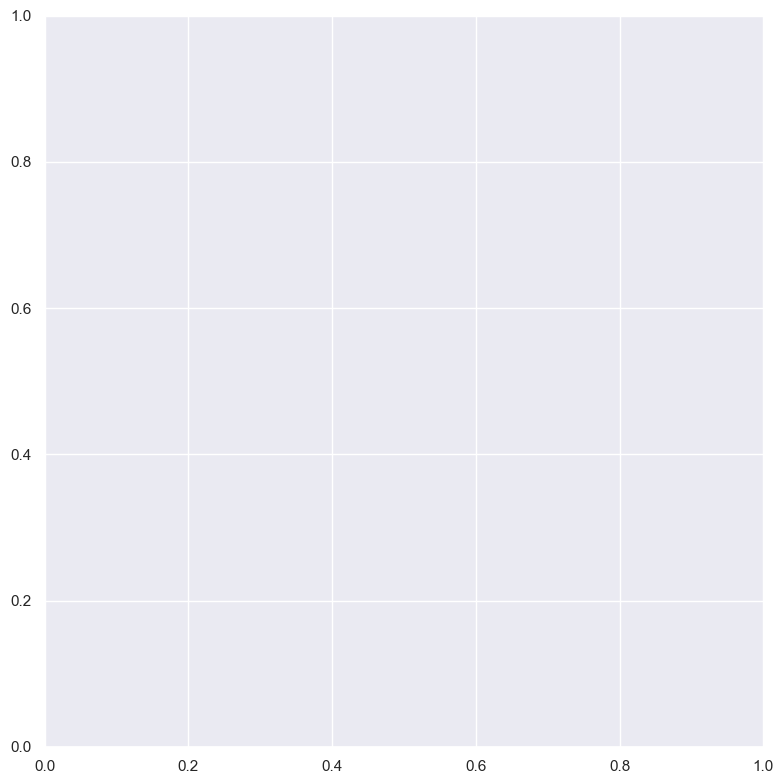

In [44]:
# Plotting without scaling y limis to 1
import seaborn as sns
sns.set_theme()
#sns.set_style('ticks')

g = sns.catplot(
    data=df, x="MIA", y="attacker_advantage", hue="Fairness",
    #palette={"male": "g", "female": "m"},
    markers=["^", "o", "x", "v", ">"], linestyles=["-", "--", "-.", ":", "-"],
    kind="point", height=8, aspect=1
)

plt.xticks(rotation=30)
g.set_axis_labels("Classifier Membership Inference Attacks", "Attacker's Advantage" )


In [ ]:
#plt.figure(figsize=(15,8))

sns.set_theme()
#sns.set_style('ticks')

g = sns.catplot(
    data=df, x="MIA", y="attacker_advantage", hue="Fairness",
    #palette={"male": "g", "female": "m"},
    markers=["^", "o", "x", "v", ">"], linestyles=["-", "--", "-.", ":", "-"],
    kind="point", height=8, aspect=1
)
plt.xticks(rotation=30)

g.set_axis_labels("Classifier Membership Inference Attacks", "Attacker's Advantage" )
g.set(ylim=(0, 1))

In [ ]:
pd.DataFrame(orig_mia_metrics_att_ad)

In [ ]:
# dataframe to display fairness metrics
# error metrics
orig_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in orig_mia_metrics.items() if k.endswith("attacker_advantage")}
transf_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in transf_mia_metrics.items() if k.endswith("attacker_advantage")}
reweigh_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in reweigh_metrics.items() if k.endswith("attacker_advantage")}
dir_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in dir_metrics.items() if k.endswith("attacker_advantage")}
egr_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in egr_metrics.items() if k.endswith("attacker_advantage")}

# mean value metrics
orig_mia_metrics_mean = {k: sum(v)/N for (k,v) in orig_mia_metrics.items() if k.endswith("attacker_advantage")}
transf_mia_metrics_mean = {k: sum(v)/N for (k,v) in transf_mia_metrics.items() if k.endswith("attacker_advantage")}
reweigh_mia_metrics_mean = {k:sum(v)/N for (k,v) in reweigh_mia_metrics.items() if k.endswith("attacker_advantage")}
dir_mia_metrics_mean = {k:sum(v)/N for (k,v) in dir_mia_metrics.items() if k.endswith("attacker_advantage")}
egr_mia_metrics_mean = {k:sum(v)/N for (k,v) in egr_mia_metrics.items() if k.endswith("attacker_advantage")}

In [ ]:
orig_mia_metrics_mean

In [ ]:
# Visuazlization of Fairness
pd.set_option('display.multi_sparse', False)
plt.rcParams.update({'font.size': 8}) # must set in top

results = [orig_mia_metrics_mean,
        transf_mia_metrics_mean,
        dir_mia_metrics_mean,
        reweigh_mia_metrics_mean,
           egr_mia_metrics_mean
        ]


errors = [orig_mia_error_metrics,
        transf_mia_error_metrics,
        dir_mia_error_metrics,
        reweigh_mia_error_metrics,
          egr_mia_error_metrics
         ]

index = pd.Series(['orig']+ ['syn']+ ['dir']+ ['rew'] + ['egr'], name='Classifier MIA Attacks')

df = pd.DataFrame(results).set_index(index)
df

In [ ]:
df.plot.bar(figsize=(7,7), ylim=[0,1])

## PPV Metric

In [ ]:
orig_mia_metrics_att_ad = {k: v for (k,v) in orig_mia_metrics.items() if k.endswith("mia_ppv")}
transf_mia_error_metrics = {k: v for (k,v) in transf_mia_metrics.items() if k.endswith("mia_ppv")}
reweigh_mia_error_metrics = {k: v for (k,v) in reweigh_mia_metrics.items() if k.endswith("mia_ppv")}
dir_mia_error_metrics = {k: v for (k,v) in dir_mia_metrics.items() if k.endswith("mia_ppv")}
egr_mia_error_metrics = {k: v for (k,v) in egr_mia_metrics.items() if k.endswith("mia_ppv")}

In [45]:
advantage_metrics_arrays = []
for key in orig_mia_metrics_att_ad.keys():
    for val in orig_mia_metrics_att_ad[key]:
        advantage_metrics_arrays.append(["orig", key.replace("_mia_ppv", ""), val])
for key in transf_mia_error_metrics.keys():
    for val in transf_mia_error_metrics[key]:
        advantage_metrics_arrays.append(["syn", key.replace("_mia_ppv", ""), val])
for key in reweigh_mia_error_metrics.keys():
    for val in reweigh_mia_error_metrics[key]:
        advantage_metrics_arrays.append(["reweigh", key.replace("_mia_ppv", ""), val])
for key in dir_mia_error_metrics.keys():
    for val in dir_mia_error_metrics[key]:
        advantage_metrics_arrays.append(["dir", key.replace("_mia_ppv", ""), val])
for key in egr_mia_error_metrics.keys():
    for val in egr_mia_error_metrics[key]:
        advantage_metrics_arrays.append(["egr", key.replace("_mia_ppv", ""), val])
advantage_metrics_arrays

NameError: name 'orig_mia_metrics_att_ad' is not defined

In [46]:
df = pd.DataFrame(advantage_metrics_arrays,columns=["Fairness", "MIA", "PPV"])
df

,Fairness,MIA,PPV


TypeError: 'NoneType' object is not iterable

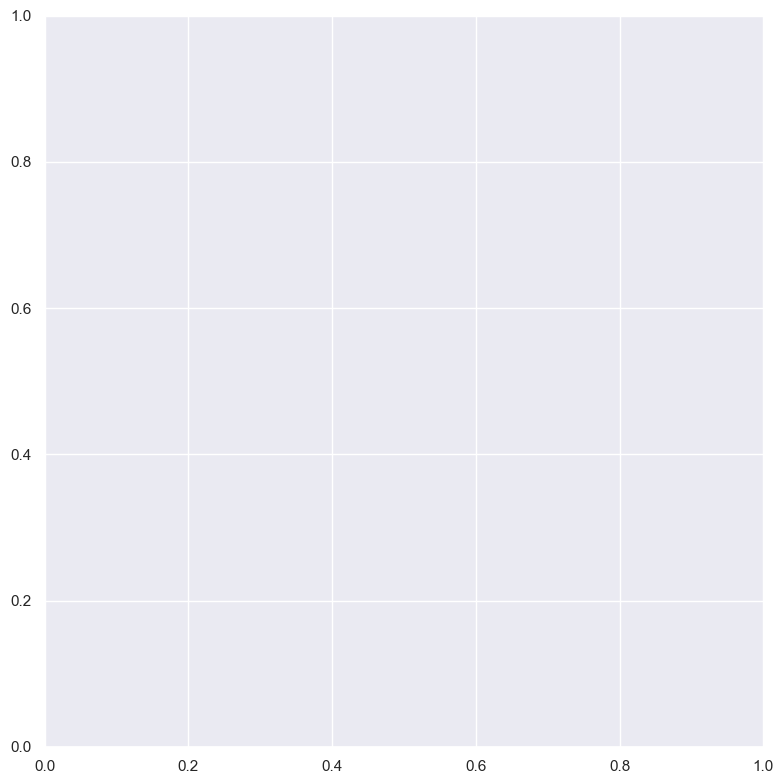

In [47]:
# Plotting without scaling y limis to 1
import seaborn as sns
sns.set_theme()
#sns.set_style('ticks')

g = sns.catplot(
    data=df, x="MIA", y="PPV", hue="Fairness",
    #palette={"male": "g", "female": "m"},
    markers=["^", "o", "x", "v", ">"], linestyles=["-", "--", "-.", ":", "-"],
    kind="point", height=8, aspect=1
)

plt.xticks(rotation=30)

g.set_axis_labels("Classifier Membership Inference Attacks", "Attacker's PPV" )


# Dataset Exploration for comparison with Shokri

In [ ]:
import pandas as pd

In [ ]:
# pd.DataFrame([dataset_orig.features, dataset_orig.labels]).drop_duplicates()

df = pd.DataFrame(dataset_orig.features, columns=dataset_orig.feature_names)

df["labels"] = dataset_orig.labels
df
#df.index

In [ ]:
df[["age", "labels"]].value_counts(normalize=True)

In [ ]:
df.drop_duplicates()